# Sales Prediction Using Machine Learning

---

## Introduction

This project predicts sales amounts based on advertising expenditure, audience segments, and advertising platforms. Machine learning models are trained to help optimize advertising strategies for maximizing sales.

---

## Step 1: Import Libraries

We start by importing necessary Python libraries for data handling, visualization, machine learning, and evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib


## Step 2: Data Preparation

Here, we create a simulated dataset that includes advertising cost, audience segment, advertising platform, and sales amount. Replace this simulation with your actual dataset loading if available.


In [2]:
np.random.seed(42)
n_samples = 500
data = pd.DataFrame({
    'Advertising_Cost': np.random.uniform(1000, 20000, n_samples),
    'Audience_Segment': np.random.choice(['Youth', 'Adult', 'Senior'], n_samples),
    'Platform': np.random.choice(['TV', 'Social Media', 'Radio'], n_samples),
})

segment_impact = {'Youth': 1.2, 'Adult': 1.0, 'Senior': 0.8}
platform_impact = {'TV': 1.5, 'Social Media': 1.3, 'Radio': 1.0}

data['Sales_Amount'] = (
        0.05 * data['Advertising_Cost'] *
        data['Audience_Segment'].map(segment_impact) *
        data['Platform'].map(platform_impact) +
        np.random.normal(0, 200, n_samples)
)


## Step 3: Feature Engineering

Generate polynomial features for advertising cost to model non-linear relationships. Convert categorical columns into one-hot encoded features for machine learning compatibility.


In [3]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(data[['Advertising_Cost']])
poly_feature_names = poly.get_feature_names_out(['Advertising_Cost'])
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)
data = pd.concat([data, poly_df.iloc[:, 1:]], axis=1)  # exclude bias term

data = pd.get_dummies(data, columns=['Audience_Segment', 'Platform'], drop_first=True)


## Step 4: Prepare Features and Target

Separate the dataset into feature variables (`X`) and the target variable (`y`).


In [4]:
X = data.drop('Sales_Amount', axis=1)
y = data['Sales_Amount']


## Step 5: Split Data

Split the data into 80% training and 20% testing sets to train and evaluate model performance fairly.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Step 6: Scale Numeric Features

Standardize numeric features to have mean zero and unit variance for better model performance.


In [6]:
scaler = StandardScaler()
numeric_cols = ['Advertising_Cost', 'Advertising_Cost^2']
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


## Step 7: Train and Evaluate Multiple Models

Train Linear Regression, Random Forest, and Gradient Boosting models to compare prediction performance on the test set.


In [9]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}")


Linear Regression - MAE: 194.06, RMSE: 233.12, R2: 0.717
Random Forest - MAE: 215.64, RMSE: 259.62, R2: 0.649
Gradient Boosting - MAE: 202.18, RMSE: 242.16, R2: 0.694


## Step 8: Hyperparameter Tuning on Random Forest

Use grid search with cross-validation to find the best parameters for the Random Forest model.


In [10]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_rf.fit(X_train, y_train)
print("Best RF params:", grid_rf.best_params_)


Best RF params: {'max_depth': 5, 'n_estimators': 50}


## Step 9: Cross-validation

Evaluate the optimized Random Forest model’s performance using 5-fold cross-validation on the entire dataset.


In [11]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(grid_rf.best_estimator_, X, y, cv=kf, scoring='r2')
print(f"Cross-validated R2 scores: {cv_scores}")
print(f"Average CV R2: {np.mean(cv_scores):.3f}")


Cross-validated R2 scores: [0.696927   0.75390821 0.74899772 0.78997111 0.78021841]
Average CV R2: 0.754


## Step 10: Residual Plot for Best Model

Inspect residuals to diagnose prediction errors for the tuned Random Forest model.


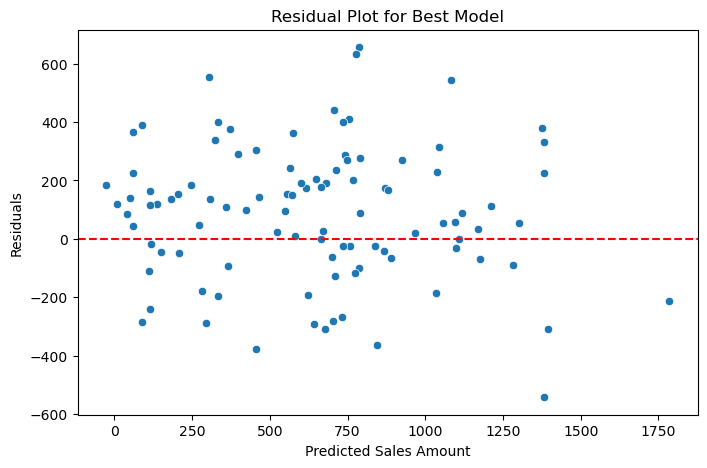

In [12]:
best_model = grid_rf.best_estimator_
y_pred_best = best_model.predict(X_test)
residuals = y_test - y_pred_best

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_best, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Sales Amount')
plt.ylabel('Residuals')
plt.title('Residual Plot for Best Model')
plt.show()


## Step 12: Feature Importance Visualization

Understanding which features most impact sales predictions helps us focus on key factors.



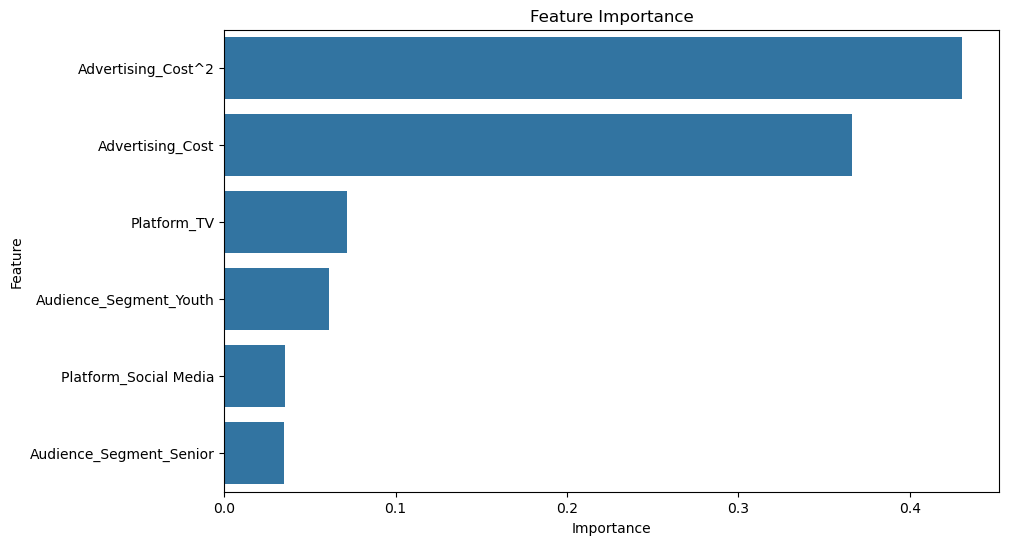

In [13]:
# Assuming best_model is a tree-based model like Random Forest or Gradient Boosting
importances = best_model.feature_importances_
feature_names = X_train.columns

feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importance')
plt.show()


## Step 13: Error Distribution Analysis

Plot a histogram of residuals to see error distribution and check for biases.


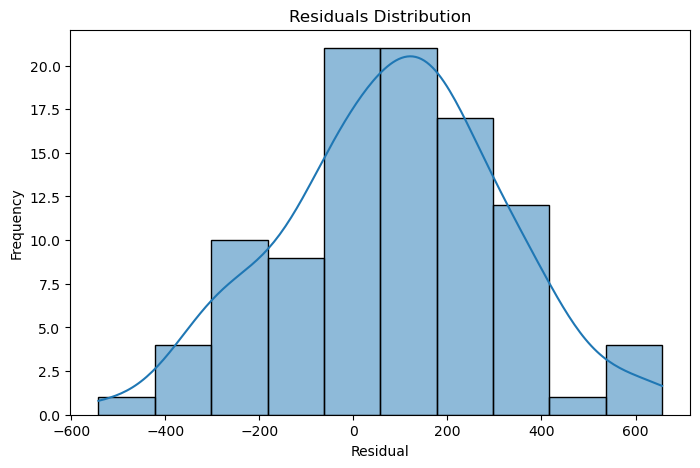

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()


## Step 14: Predicted vs Actual Comparison

A scatter plot comparing predicted sales against actual sales to evaluate model accuracy visually.


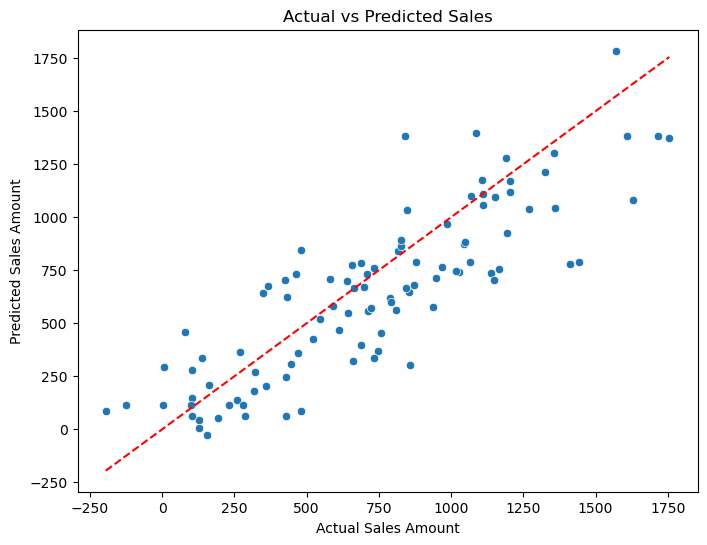

In [15]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_best)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sales Amount')
plt.ylabel('Predicted Sales Amount')
plt.title('Actual vs Predicted Sales')
plt.show()


## Step 16: Conclusion

This enriched model analysis reveals which features are critical, checks where prediction errors occur, and visually compares predictions with actual sales.  
Saving the model prepares it for deployment or further use.
